## Cat and Dog Detection - Image Classification con Data Augmentation

En esta tarea tendrán que crear un modelo de clasificación que sea capaz de predecir correctamente si en una foto hay un perro o un gato. Utilizarán el dataset `cats_and_dogs.zip`.

---

#### 01. Data Augmentation con `imgaug`

- Crea una pipeline con `iaa.Sequential` que aplique varias transformaciones a las imágenes.
- La transformación final de la pipeline será un `iaa.Resize`. Esta pipeline será de entrenamiento.
- Visualiza varias de las fotos que salen de esa pipeline para asegurarte de que las transformaciones no arruinan las imágenes.
- Crea otra pipeline que solo aplique un `iaa.Resize`. Esta pipeline será de test.

#### 02. Generador de Datos con `PyDataset`

- Crea una clase que herede de `keras.utils.PyDataset`. Esta clase se encargará de agrupar las fotos en batches y alimentarlas a la red neuronal. Además de esto, aplicará las transformaciones de la pipeline de aumentado de datos a cada foto antes de añadirla al batch.
- Separa tus datos en train y test, y crea un dataset para cada conjunto de datos.

#### 03. Modelo de Clasificación (Deep Learning)

- Diseña una arquitectura CNN básica que pueda tomar una imágen a color y retornar la etiqueta de perro o gato.
- Utiliza uno o dos bloques convolucionales.
- Utiliza una o dos capas densas profundas.

#### 04. Entrenamiento y Evaluación

- Entrena el modelo entre 20 y 50 épocas.
- Haz un plot de los resultados, concretamente la evolución del loss (train y val) y del accuracy (train y val). Además de esto, dibuja la matriz de confusión.

#### 05. Análisis de Resultados y Conclusiones

- ¿Está el modelo aprendiendo correctamente?
- ¿Está el modelo generalizando bien lo aprendido?
- ¿Comete más falsos positivos o falsos negativos?
- Piensa muy bien acerca de estas preguntas, y también reflexiona acerca de las causas de las cosas que no salen bien (por ejemplo, el modelo no generaliza bien).

#### 06. Primera Iteración
- Basándote en tu reflexión, haz cambios a tu código. Puedes modificar tu pipeline, la arquitectura, o utilizar técnicas de regularización como Dropouts y Callbacks. Juega con diferentes optimizadores y el learning rate, o prueba entrenar más tiempo.
- Haz como máximo dos cambios, pero idealmente solo uno.
- Justifica por escrito los cambios.
- Importante: No cambies el código que ya tengas hecho. Haz un apartado nuevo en tu notebook y escribe ahí la nueva versión.

#### 07. Segunda Iteración
- Repite el punto 06.

#### 08. Última Iteración
- Repite el punto 06.

In [ ]:
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.utils import PyDataset

import albumentations as A

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

import cv2

c:\Users\csd\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
IMG_DIR = "Data/img/cats_and_dogs"

# Ruta de las dos carpetas
cat_dir = os.path.join(IMG_DIR, "cats")
dog_dir = os.path.join(IMG_DIR, "dogs")

# Listar imágenes y crear dos dataframe y luego unirlos en uno solo
cat_files = os.listdir(cat_dir)
dog_files = os.listdir(dog_dir)

df_cats = pd.DataFrame({
    "img_path": [os.path.join(cat_dir, file) for file in cat_files],
    "label": "cat"})

df_dogs = pd.DataFrame({
    "img_path": [os.path.join(dog_dir, file) for file in dog_files],
    "label": "dog"})

df = pd.concat([df_cats, df_dogs], ignore_index=True)


print(len(cat_files))
print(len(dog_files))

df

print(df.head())
print(df["label"].value_counts())

2000
2000
                                   img_path label
0     Data/img/cats_and_dogs\cats\cat.0.jpg   cat
1     Data/img/cats_and_dogs\cats\cat.1.jpg   cat
2    Data/img/cats_and_dogs\cats\cat.10.jpg   cat
3   Data/img/cats_and_dogs\cats\cat.100.jpg   cat
4  Data/img/cats_and_dogs\cats\cat.1000.jpg   cat
label
cat    2000
dog    2000
Name: count, dtype: int64


(374, 500, 3)


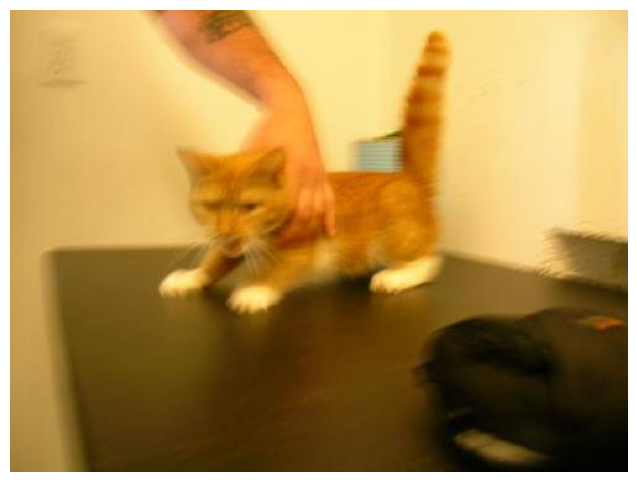

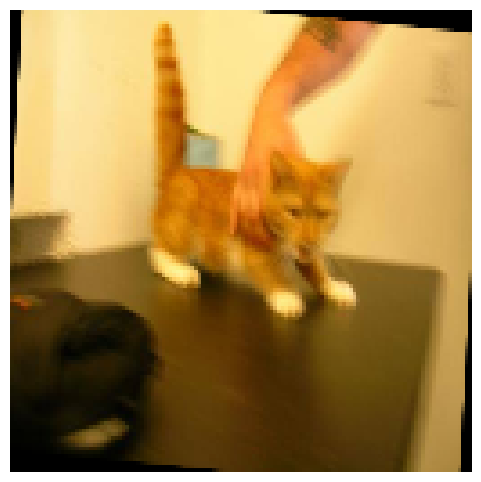

(128, 128, 3)


In [5]:
## 01. Data Augmentation con imgaug/Albumentations.

# - Crea una pipeline con iaa.Sequential que aplique varias transformaciones a las imágenes. 
   
SIZE = 128            
CHANNELS = 3         
BATCH_SIZE = 16      

# - La transformación final de la pipeline será un iaa.Resize. Esta pipeline será de entrenamiento. 
train_seq = A.Compose([A.HorizontalFlip(p=0.5),
            A.GaussianBlur(sigma_limit=(0.0, 1.0), p=0.3),
            A.Rotate(limit=(-10, 10), p=0.4),
            A.Resize(height=SIZE, width=SIZE,p=1.0)])

# - Crea otra pipeline que solo aplique un iaa.Resize. Esta pipeline será de test.
test_seq = A.Compose([A.Resize(height=SIZE, width=SIZE, p=1.0)])

# - Visualiza varias de las fotos que salen de esa pipeline para asegurarte de que las transformaciones no arruinan las imágenes.
sample_path = df.iloc[0]["img_path"]
img = cv2.imread(sample_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

plt.figure(figsize=(12, 6))

plt.imshow(img)
plt.axis("off")
plt.show()

transform = train_seq(image=img)
transformed_img = transform["image"]
plt.figure(figsize=(6, 6))
plt.imshow(transformed_img)
plt.axis("off")
plt.show()

print(transformed_img.shape)

(449, 433, 3)


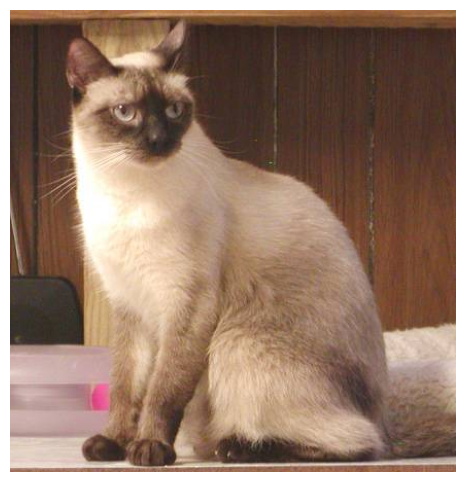

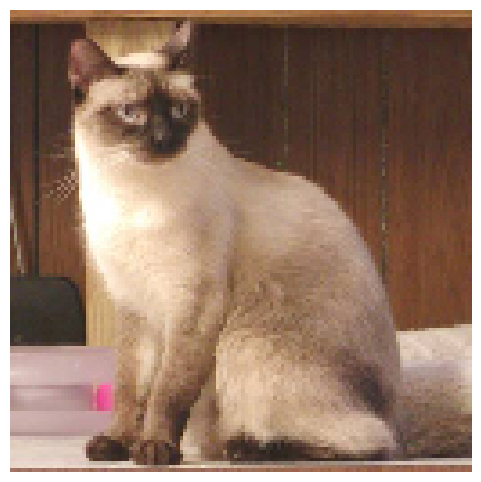

(128, 128, 3)


In [6]:
sample_path = df.iloc[1000]["img_path"]
img = cv2.imread(sample_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

plt.figure(figsize=(12, 6))

plt.imshow(img)
plt.axis("off")
plt.show()

transform = train_seq(image=img)
transformed_img = transform["image"]
plt.figure(figsize=(6, 6))
plt.imshow(transformed_img)
plt.axis("off")
plt.show()

print(transformed_img.shape)

(269, 141, 3)


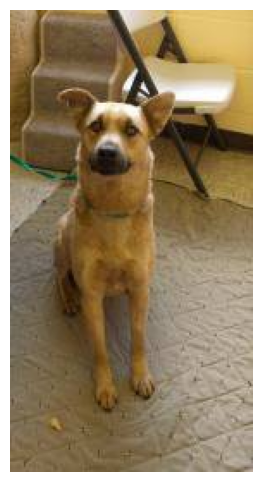

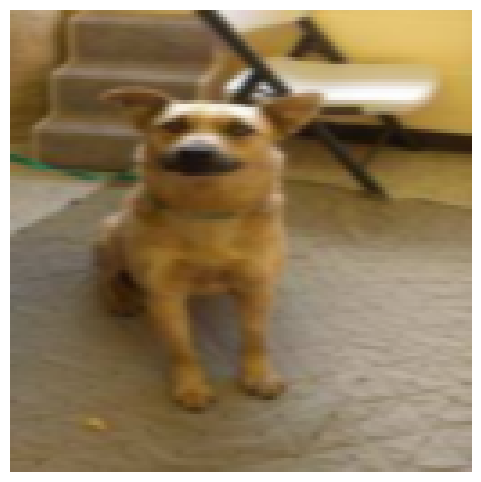

(128, 128, 3)


In [7]:
sample_path = df.iloc[3000]["img_path"]
img = cv2.imread(sample_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

plt.figure(figsize=(12, 6))

plt.imshow(img)
plt.axis("off")
plt.show()

transform = train_seq(image=img)
transformed_img = transform["image"]
plt.figure(figsize=(6, 6))
plt.imshow(transformed_img)
plt.axis("off")
plt.show()

print(transformed_img.shape)

In [8]:
## 02. Generador de Datos con PyDataset 
# - Crea una clase que herede de keras.utils.PyDataset. 
    # Esta clase se encargará de agrupar las fotos en batches y alimentarlas a la red neuronal. 
    # Además de esto, aplicará las transformaciones de la pipeline de aumentado de datos a cada foto antes de añadirla al batch. 
class CatsDogsDataset(PyDataset):
    def __init__(self, df, aug, batch_size=BATCH_SIZE, train=True, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)  
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()
    
    def __len__(self):
                return int(np.ceil(len(self.df) / self.batch_size)) # con np.ceil: Incluye el último batch aunque esté incompleto

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df)) 
        if self.train:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        
        batch_indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        return self.__data_generation(batch_df)

    def __data_generation(self, batch_df):
        # Batch vacío
        batch_images = np.empty((len(batch_df), SIZE, SIZE, CHANNELS), dtype=np.float32)
        batch_labels = np.empty((len(batch_df),), dtype=np.int32)

        # Llenamos el batch con imágenes aumentados
        for i, (_,row) in enumerate(batch_df.iterrows()):
        
            img = cv2.imread(row["img_path"])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Aplicamos pipeline de data augmentation
            img = self.aug(image=img)["image"]

            # LLenamos el batch
            batch_images[i] = img
            batch_labels[i] = 0.0 if row["label"] == "cat" else 1.0

        # Escalado de datos
        batch_images = batch_images / 255.0
        

        return batch_images, batch_labels.astype(np.float32)
    
    
# - Separa tus datos en train y test, y crea un dataset para cada conjunto de datos.
paths = df["img_path"].tolist()
labels = df["label"].tolist()

train_paths, test_paths, train_labels, test_labels = train_test_split(paths, labels, test_size=0.15, random_state=42, stratify=labels)

train_df = pd.DataFrame({"img_path": train_paths, "label":train_labels})
test_df = pd.DataFrame({"img_path": test_paths, "label":test_labels})

# Crear datasets
train_dataset = CatsDogsDataset(train_df, train_seq)
test_dataset = CatsDogsDataset(test_df, test_seq, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(test_dataset)}")

Total batches in training set: 213
Total batches in validation set: 38


In [9]:
## 03. Modelo de Clasificación (Deep Learning) 
# - Diseña una arquitectura CNN básica que pueda tomar una imágen a color y retornar la etiqueta de perro o gato. 
# - Utiliza uno o dos bloques convolucionales. 
# - Utiliza una o dos capas densas profundas.
optimizer = Adam()

model = Sequential()
model.add(Input(shape = (SIZE, SIZE, CHANNELS)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units = 128, activation = "relu"))
model.add(Dense(units = 64, activation = "relu"))
model.add(Dense(units = 1, activation = "sigmoid"))

    # Compila el modelo.
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=[BinaryAccuracy()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,409,889 (28.27 MB)

 Trainable params: 7,409,889 (28.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 139s 637ms/step - binary_accuracy: 0.5462 - loss: 0.6938 - val_binary_accuracy: 0.6667 - val_loss: 0.6488
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 114s 533ms/step - binary_accuracy: 0.5965 - loss: 0.6605 - val_binary_accuracy: 0.5550 - val_loss: 0.7123
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 72s 334ms/step - binary_accuracy: 0.6591 - loss: 0.6095 - val_binary_accuracy: 0.6567 - val_loss: 0.6105
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 76s 356ms/step - binary_accuracy: 0.7188 - loss: 0.5632 - val_binary_accuracy: 0.7100 - val_loss: 0.5824
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 69s 325ms/step - binary_accuracy: 0.7462 - loss: 0.5069 - val_binary_accuracy: 0.7317 - val_loss: 0.5510
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 71s 333ms/step - binary_accuracy: 0.7724 - loss: 0.4755 - val_binary_accuracy: 0.7383 - val_loss: 0.5594
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 70s 329ms/step - binary_accuracy: 0.7968 - loss: 0.4344 - val_binary_accuracy: 0.7133 - 

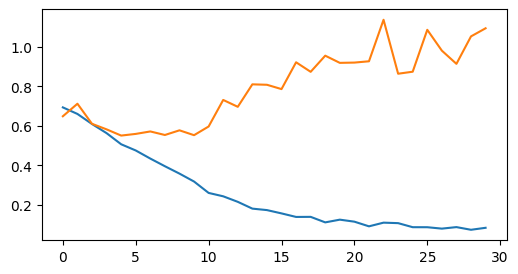

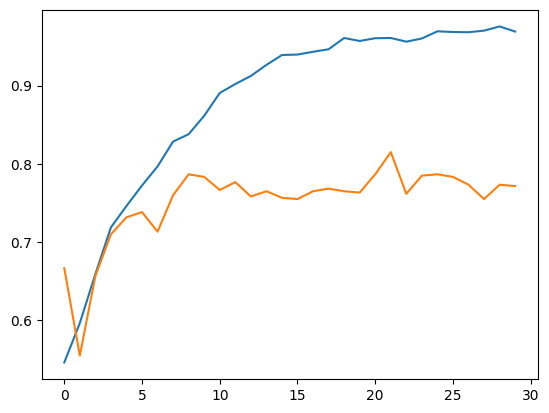

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step


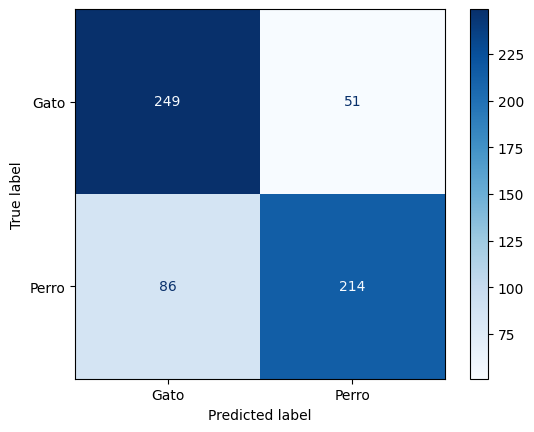

In [10]:
## 04. Entrenamiento y Evaluación 
# - Entrena el modelo entre 20 y 50 épocas. 
# - Haz un plot de los resultados, concretamente la evolución del loss (train y val) y del accuracy (train y val). 
# Además de esto, dibuja la matriz de confusión.
EPOCHS = 30

history = model.fit(train_dataset, 
                    validation_data = test_dataset, 
                    epochs=EPOCHS)

plt.figure(figsize=(6,3))
plt.plot(history.epoch, history.history["loss"], label="train_loss")
plt.plot(history.epoch, history.history["val_loss"], label="val_loss")
plt.show()

plt.plot(history.epoch, history.history["binary_accuracy"], label="train_acc")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="val_acc")
plt.show()

yhat = model.predict(test_dataset)

yhat_labels = (yhat > 0.5).astype(int).flatten()

y_true = y_true = test_df["label"].map(lambda x: 0 if x=="cat" else 1).values

# Matriz de confusión

cm = confusion_matrix(y_true, yhat_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Gato', 'Perro'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 05. Análisis de Resultados y Conclusiones 
- ¿Está el modelo aprendiendo correctamente? 
binary_accuracy mayor del 95% y loss bajo. Está entrenando bien.
En validación (val_binary_accuracy) se queda en en torno al 78% y val_loss va bajando pero luego sube mucho.
Es decir, está aprendiendo pero no está prediciendo bien.
Esto puede ser overfitting.
- ¿Está el modelo generalizando bien lo aprendido? 
No. Hay mucha diferencia entre entrenamiento y validación.
- ¿Comete más falsos positivos o falsos negativos? 
Hay más falsos negativos.
- Piensa muy bien acerca de estas preguntas, y también reflexiona acerca de las causas de las cosas que no salen bien (por ejemplo, el modelo no generaliza bien).
No generaliza bien. A lo mejor necesita aumento de datos y cambiar el pipeline.

Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 68s 321ms/step - binary_accuracy: 0.9762 - loss: 0.0700 - val_binary_accuracy: 0.7683 - val_loss: 1.0713
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 65s 303ms/step - binary_accuracy: 0.9744 - loss: 0.0686 - val_binary_accuracy: 0.7400 - val_loss: 1.2300
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 61s 287ms/step - binary_accuracy: 0.9691 - loss: 0.0777 - val_binary_accuracy: 0.7767 - val_loss: 1.0224
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 76s 356ms/step - binary_accuracy: 0.9809 - loss: 0.0578 - val_binary_accuracy: 0.7667 - val_loss: 1.0489
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 63s 297ms/step - binary_accuracy: 0.9812 - loss: 0.0481 - val_binary_accuracy: 0.7733 - val_loss: 1.2215
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 63s 298ms/step - binary_accuracy: 0.9774 - loss: 0.0683 - val_binary_accuracy: 0.7867 - val_loss: 1.1310
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 65s 306ms/step - binary_accuracy: 0.9735 - loss: 0.0711 - val_binary_accuracy: 0.7933 - va

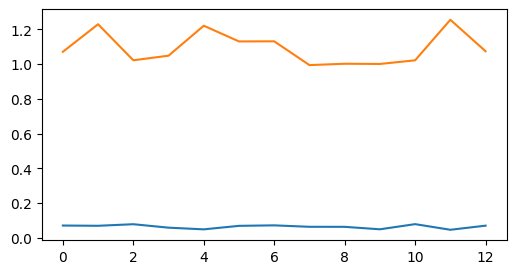

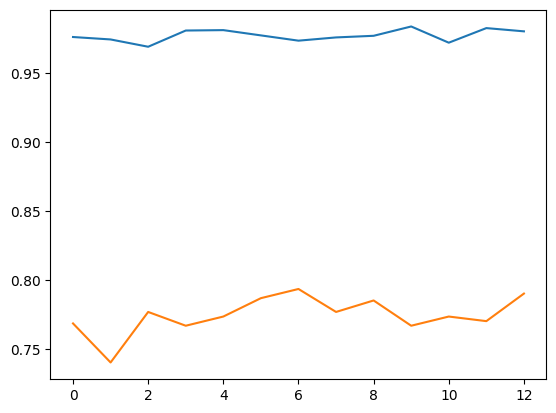

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


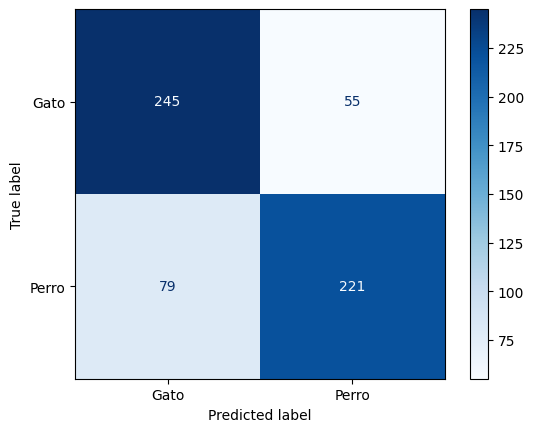

In [11]:
## 06. Primera Iteración 
# - Basándote en tu reflexión, haz cambios a tu código. 
    # Puedes modificar tu pipeline, la arquitectura, o utilizar técnicas de regularización como Dropouts y Callbacks. 
    # Juega con diferentes optimizadores y el learning rate, o prueba entrenar más tiempo. 
# - Haz como máximo dos cambios, pero idealmente solo uno. 
# - Justifica por escrito los cambios. 
# - Importante: No cambies el código que ya tengas hecho. Haz un apartado nuevo en tu notebook y escribe ahí la nueva versión.

# Callback para detener entrenamiento si la val_loss no mejora
early_stop = EarlyStopping(monitor="val_loss", 
                           patience=5, 
                           restore_best_weights=True)

# Callback para guardar el mejor modelo
checkpoint = ModelCheckpoint("mejor_modelo.keras",
                             monitor="val_loss",
                             save_best_only=True)

history_1= model.fit(train_dataset,
                     validation_data=test_dataset,
                     epochs=30,
                     callbacks=[early_stop, checkpoint])

plt.figure(figsize=(6,3))
plt.plot(history_1.epoch, history_1.history["loss"])
plt.plot(history_1.epoch, history_1.history["val_loss"])
plt.show()

plt.plot(history_1.epoch, history_1.history["binary_accuracy"], label="train_acc")
plt.plot(history_1.epoch, history_1.history["val_binary_accuracy"], label="val_acc")
plt.show()

yhat = model.predict(test_dataset)

yhat_labels = (yhat > 0.5).astype(int).flatten()

y_true = np.concatenate([labels for _, labels in test_dataset], axis=0).flatten()

# Matriz de confusión

cm = confusion_matrix(y_true, yhat_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Gato', 'Perro'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Justificación escrita

Se añade EarlyStopping y ModelCheckpoint. 

EarlyStopping para que el entrenamiento pare cuando la pérdida de validación deja de mejorar. para poder evitar que el modelo se sobreajuste al conjunto de entrenamiento. 

ModelCheckpoint guarda automáticamente el modelo con mejor desempeño en validación. La idea es mejorar la generalización y reducir los errores.

C:\Users\csd\AppData\Roaming\Python\Python311\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,302,209 (16.41 MB)

 Trainable params: 4,302,209 (16.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 56s 244ms/step - binary_accuracy: 0.4897 - loss: 0.6964 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 222ms/step - binary_accuracy: 0.5244 - loss: 0.6913 - val_binary_accuracy: 0.5483 - val_loss: 0.6798
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 38s 179ms/step - binary_accuracy: 0.5076 - loss: 0.6940 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - binary_accuracy: 0.5044 - loss: 0.6925 - val_binary_accuracy: 0.5300 - val_loss: 0.6838
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - binary_accuracy: 0.5271 - loss: 0.6900 - val_binary_accuracy: 0.5000 - val_loss: 0.6933
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 47s 221ms/step - binary_accuracy: 0.5003 - loss: 0.6927 - val_binary_accuracy: 0.5000 - val_loss: 0.6925
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 51s 238ms/step - binary_accuracy: 0.5194 - loss: 0.6855 - val_binary_accuracy: 0.5850 - va

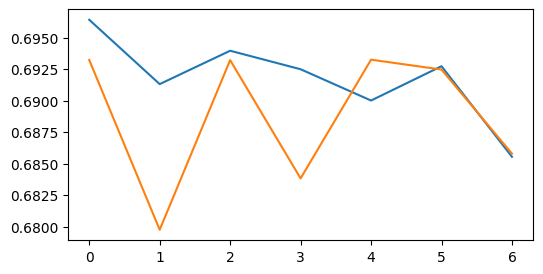

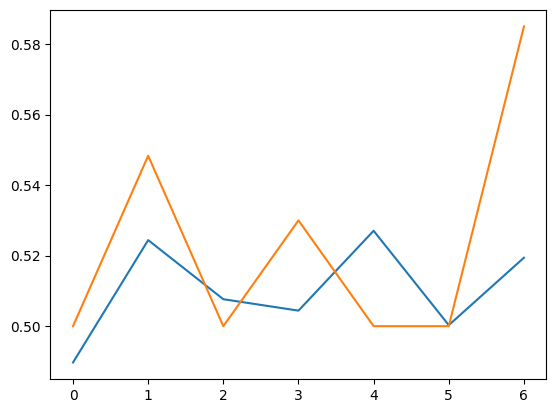

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


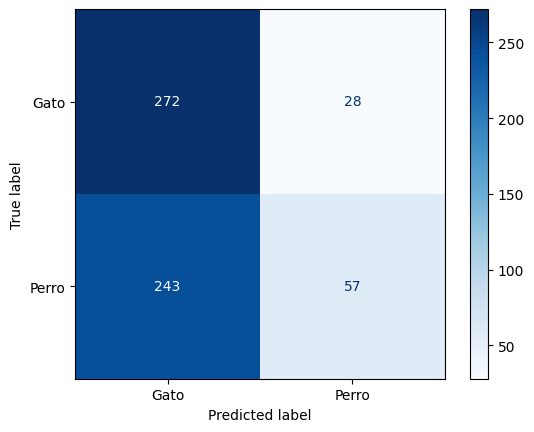

In [ ]:
#### 07. Segunda Iteración - Repite el punto 06.

# Definir transformaciones para entrenamiento

train_transforms = A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.RandomBrightnessContrast(p=0.2),
                    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
                    A.Resize(SIZE, SIZE)])

test_transforms = A.Compose([A.Resize(SIZE, SIZE)])

train_dataset = CatsDogsDataset(train_df, train_transforms, batch_size=BATCH_SIZE)
test_dataset = CatsDogsDataset(test_df, test_transforms, batch_size=BATCH_SIZE, train=False)

# Definir modelo
model2 = Sequential()

# Entrada
model2.add(Input(shape=(128,128,3)))  # Ajusta según tus imágenes

# Bloques convolucionales
model2.add(Conv2D(32, (3,3), activation="relu", padding="same"))
model2.add(MaxPooling2D((2,2)))

model2.add(Conv2D(64, (3,3), activation="relu", padding="same"))
model2.add(MaxPooling2D((2,2)))

model2.add(Conv2D(128, (3,3), activation="relu", padding="same"))
model2.add(MaxPooling2D((2,2)))

# Aplanar
model2.add(Flatten())

# Capas ocultas con Dropout

model2.add(Dense(128, activation="relu"))
model2.add(Dropout(0.3))

model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.3))

model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.2))

model2.add(Dense(32, activation="relu"))

# Capa de salida binaria
model2.add(Dense(1, activation="sigmoid"))

# Resumen del modelo
model2.summary()

# Compilación
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

# Entrenamiento
history_2 = model2.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)
plt.figure(figsize=(6,3))
plt.plot(history_2.epoch, history_2.history["loss"])
plt.plot(history_2.epoch, history_2.history["val_loss"])
plt.show()

plt.plot(history_2.epoch, history_2.history["binary_accuracy"], label="train_acc")
plt.plot(history_2.epoch, history_2.history["val_binary_accuracy"], label="val_acc")
plt.show()

yhat = model2.predict(test_dataset)

yhat_labels = (yhat > 0.5).astype(int).flatten()

y_true = np.concatenate([labels for _, labels in test_dataset], axis=0).flatten()

# Matriz de confusión

cm = confusion_matrix(y_true, yhat_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Gato', 'Perro'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Justificación escrita segunda iteración

Se mete Dropout en las capas densas del modelo (30% de neuronas desactivadas aleatoriamente en cada capa oculta). El objetivo principal era reducir el sobreajuste y mejorar la generalización del modelo sobre los datos de validación.

Se observa una mejora pero aún hay muchos falsos negativos.

Intuyo que el Dropout a lo mejor es demasiado alto.

C:\Users\csd\AppData\Roaming\Python\Python311\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,180,737 (80.80 MB)

 Trainable params: 6,466,049 (24.67 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 823s 4s/step - binary_accuracy: 0.7185 - loss: 0.5500 - val_binary_accuracy: 0.8617 - val_loss: 0.3613
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 881s 4s/step - binary_accuracy: 0.8700 - loss: 0.3019 - val_binary_accuracy: 0.8850 - val_loss: 0.2395
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 814s 4s/step - binary_accuracy: 0.8956 - loss: 0.2574 - val_binary_accuracy: 0.9017 - val_loss: 0.2117
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 804s 4s/step - binary_accuracy: 0.9071 - loss: 0.2324 - val_binary_accuracy: 0.9067 - val_loss: 0.1989
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 823s 4s/step - binary_accuracy: 0.9168 - loss: 0.2005 - val_binary_accuracy: 0.9083 - val_loss: 0.1864
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 806s 4s/step - binary_accuracy: 0.9229 - loss: 0.1790 - val_binary_accuracy: 0.9100 - val_loss: 0.2110
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 831s 4s/step - binary_accuracy: 0.9279 - loss: 0.1732 - val_binary_accuracy: 0.9167 - val_loss: 0.1855

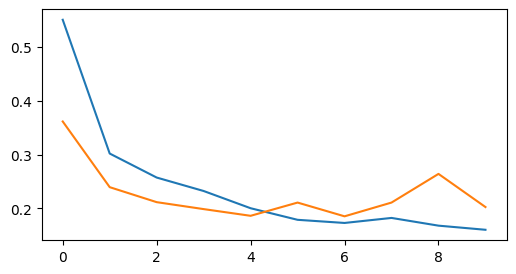

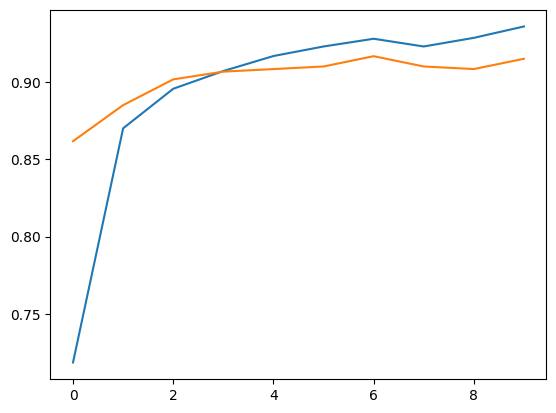

38/38 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step


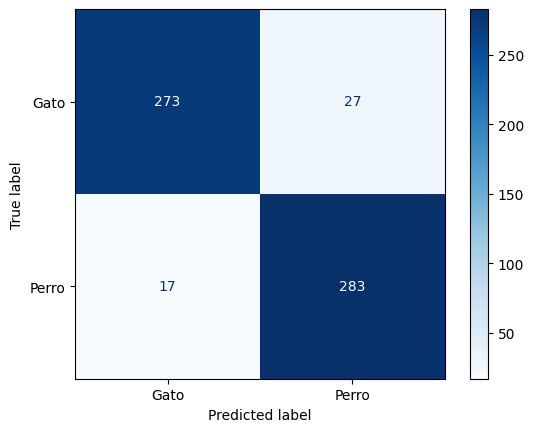

In [13]:
#### 08. Última Iteración - Repite el punto 06.

SIZE = 224  # antes era 128

train_transforms = A.Compose([
                   A.HorizontalFlip(p=0.5),
                   A.RandomBrightnessContrast(p=0.2),
                   A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
                   A.Resize(SIZE, SIZE)])

test_transforms = A.Compose([A.Resize(SIZE, SIZE)])

train_dataset = CatsDogsDataset(train_df, train_transforms, batch_size=BATCH_SIZE)
test_dataset  = CatsDogsDataset(test_df, test_transforms, batch_size=BATCH_SIZE, train=False)

model_vgg16 = VGG16(weights = "imagenet",
              include_top = False,
              input_shape = (224, 224, 3),
              classes = 1000)
model_vgg16.trainable = False

model_vgg16.summary()

# Definir modelo
model3 = Sequential()

# Entrada
model3.add(model_vgg16)

# Aplanar
model3.add(Flatten())

# Capas ocultas con Dropout
model3.add(Dense(256, activation="relu"))
model3.add(Dropout(0.2)) 

model3.add(Dense(128, activation="relu"))
model3.add(Dropout(0.2))

model3.add(Dense(64, activation="relu"))
model3.add(Dropout(0.2))

model3.add(Dense(32, activation="relu"))

# Capa de salida binaria
model3.add(Dense(1, activation="sigmoid"))

# Resumen del modelo
model3.summary()

# Compilación
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

# Entrenamiento
history_3 = model3.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=[early_stop, checkpoint])

plt.figure(figsize=(6,3))
plt.plot(history_3.epoch, history_3.history["loss"])
plt.plot(history_3.epoch, history_3.history["val_loss"])
plt.show()

plt.plot(history_3.epoch, history_3.history["binary_accuracy"], label="train_acc")
plt.plot(history_3.epoch, history_3.history["val_binary_accuracy"], label="val_acc")
plt.show()

yhat = model3.predict(test_dataset)

threshold = 0.4
yhat_labels = (yhat > threshold).astype(int).flatten()

y_true = np.concatenate([labels for _, labels in test_dataset], axis=0).flatten()

# Matriz de confusión

cm = confusion_matrix(y_true, yhat_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Gato', 'Perro'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Justificación escrita tercera iteración

En esta última iteración se usa Transfer Learning con VGG16. La idea es aprovechar conocimientos aprendidos para mejorar la generalización y reducir overfitting, sin entrenar desde cero.

Aumento el tamaño de las imágenes a 224x224, tamaño requerido por VGG16.

Esto permite que la red preentrenada reciba la resolución adecuada y extraiga características más precisas.

Se cambian las capas densas con Dropout(0.2) para no perder demasiada información.

Se redujo el threshold a 0.4 en la salida sigmoide para mejorar la detección de perros y reducir falsos negativos.

Resultado observado:

Hay una evidente mejora en la validación y se reducen mucho los falsos negativos.
Predice adecuadamente más del 90% de perros y más del 90% de gatos.

Tarda aproximadamente 2 horas y 30 minutos para 10 epochs.